link gdrive : https://drive.google.com/drive/folders/1YwwKYx5nVoIPzTuQqHL_8tHS0heYF8A0?usp=sharing

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import random

IMG_SIZE = (160, 160)
BATCH_SIZE = 16
NUM_CLASSES = 4
CLASS_NAMES_ORDER = ['bika ambon', 'kerak telor', 'papeda', 'plecing kangkung']
DATA_DIR = r"C:\Users\LENOVO\Projek-UAS-PMDPM_A_KERAS\dataset"

train_dir = os.path.join(DATA_DIR, "train")
val_dir = os.path.join(DATA_DIR, "val")
test_dir = os.path.join(DATA_DIR, "test")



In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
ALLOWED_EXT = {".jpg", ".jpeg", ".png"} 
test_root = test_dir  

bad_files = []

for class_name in os.listdir(test_root):
    class_path = os.path.join(test_root, class_name)
    if not os.path.isdir(class_path):
        continue
    for fname in os.listdir(class_path):
        fpath = os.path.join(class_path, fname)
        ext = os.path.splitext(fname)[1].lower()
        if os.path.isfile(fpath) and ext not in ALLOWED_EXT:
            bad_files.append(fpath)

print("File bermasalah (tidak didukung):")
for bf in bad_files:
    print(" -", bf)

print("Jumlah file bermasalah:", len(bad_files))

File bermasalah (tidak didukung):
Jumlah file bermasalah: 0


## Data Loading

In [4]:
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical", 
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    shuffle = False
)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)



Found 241 files belonging to 4 classes.
Found 29 files belonging to 4 classes.
Found 32 files belonging to 4 classes.


In [5]:
class_names =  train_ds.class_names
print("Class names:", class_names)
class_names =  val_ds.class_names
print("Class names:", class_names)
class_names =  test_ds.class_names
print("Class names:", class_names)

Class names: ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']
Class names: ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']
Class names: ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']


In [13]:
for split_name, split_dir in [('train', train_dir), ('val', val_dir)]:
    print(f"\n{split_name.upper()}")
    for cls in sorted(os.listdir(split_dir)):
        p = os.path.join(split_dir, cls)
        if os.path.isdir(p):
            print(f"{cls:20s} -> {len(os.listdir(p))} gambar")



TRAIN
bika ambon           -> 60 gambar
kerak telur          -> 60 gambar
papeda               -> 61 gambar
plecing kangkung     -> 60 gambar

VAL
bika ambon           -> 7 gambar
kerak telur          -> 7 gambar
papeda               -> 8 gambar
plecing kangkung     -> 7 gambar


## Normalisasi Dan Augmentasi

In [6]:
normalization_layer = layers.Rescaling(1./255)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# # Helper untuk lihat sample data setelah augmentasi
# def show_sample(dataset, n=4):
#     plt.figure(figsize=(8,8))
#     for images, labels in dataset.take(1):
#         images = images[:n]
#         labels = labels[:n]
#         for i in range(n):
#             ax = plt.subplot(2, 2, i + 1)
#             aug_img = data_augmentation(images[i:i+1])
#             plt.imshow(aug_img[0].numpy().astype("uint8"))
#             class_idx = np.argmax(labels[i].numpy())
#             plt.title(CLASS_NAMES_ORDER[class_idx])
#             plt.axis("off")
#     plt.show()

# show_sample(train_ds, n=4) 

## 4. Blok Depthwise Separable Conv

In [7]:
def depthwise_block(x, pointwise_filters, stride):
    # Depthwise
    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding="same",  depthwise_regularizer=l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)

    # Pointwise (1x1)
    x = layers.Conv2D(pointwise_filters, kernel_size=1, strides=1, padding="same", kernel_regularizer=l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)
    return x

## 5. Arsitektur MobileNet-style

In [8]:
def build_mobilenet_like(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    # augmentasi & normalisasi
    x = data_augmentation(inputs)
    x = normalization_layer(x)

    # stem conv awal
    x = layers.Conv2D(
        32,
        kernel_size=3,
        strides=2,
        padding="same",
        kernel_regularizer=l2(0.0005)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)

    # tumpukan depthwise separable conv
    x = depthwise_block(x, pointwise_filters=64,  stride=1)
    x = depthwise_block(x, pointwise_filters=128, stride=2)
    x = depthwise_block(x, pointwise_filters=128, stride=1)
    x = depthwise_block(x, pointwise_filters=256, stride=2)
    x = depthwise_block(x, pointwise_filters=256, stride=1)
    x = depthwise_block(x, pointwise_filters=512, stride=2)

    # ulang blok 512 beberapa kali
    for _ in range(4):
        x = depthwise_block(x, pointwise_filters=512, stride=1)

    # blok akhir besar
    x = depthwise_block(x, pointwise_filters=1024, stride=2)
    x = depthwise_block(x, pointwise_filters=1024, stride=1)

    # head klasifikasi
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=l2(0.001)
    )(x)

    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(
        num_classes,
        activation="softmax"
    )(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="MobileNet_like_custom")
    return model


model = build_mobilenet_like()
model.summary()  # <-- ini memenuhi rubrik "model summary"

Model: "MobileNet_like_custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 80, 80, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 40, 40, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 40, 40, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,099,652 (11.82 MB)

 Trainable params: 3,079,812 (11.75 MB)

 Non-trainable params: 19,840 (77.50 KB)

## 6. Modile Compile

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## 7. Training

In [10]:
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,                     # boleh 20 atau 30
    callbacks=[earlystop, reduceLR]
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 410ms/step - accuracy: 0.3237 - loss: 4.1365 - val_accuracy: 0.2414 - val_loss: 4.0050 - learning_rate: 0.0010
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.3693 - loss: 4.0256 - val_accuracy: 0.2414 - val_loss: 4.0028 - learning_rate: 0.0010
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.5477 - loss: 3.6938 - val_accuracy: 0.2414 - val_loss: 4.0229 - learning_rate: 0.0010
Epoch 4/20
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.5474 - loss: 3.5864
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.5560 - loss: 3.5071 - val_accuracy: 0.2414 - val_loss: 4.0036 - learning_rate: 0.0010
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.6805 - loss: 3.3522 - val_accuracy: 0.2414 - val_loss: 4.0154 - learning_rate: 5.0000e-04


## 8. Plot akurasi & loss

   accuracy      loss  val_accuracy  val_loss  learning_rate
0  0.323651  4.136537      0.241379  4.004954         0.0010
1  0.369295  4.025608      0.241379  4.002817         0.0010
2  0.547718  3.693841      0.241379  4.022898         0.0010
3  0.556017  3.507094      0.241379  4.003619         0.0010
4  0.680498  3.352206      0.241379  4.015421         0.0005


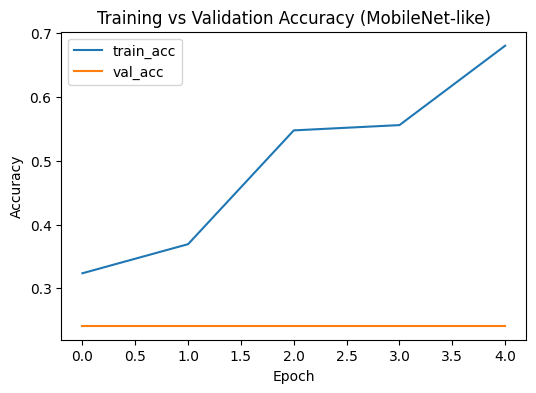

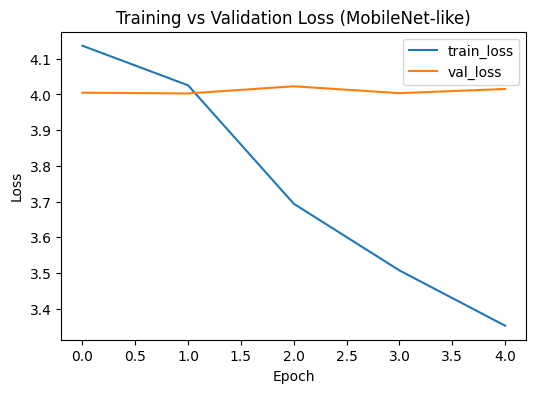

In [11]:
hist_df = pd.DataFrame(history.history)
print(hist_df.head())

plt.figure(figsize=(6,4))
plt.plot(hist_df["accuracy"], label="train_acc")
plt.plot(hist_df["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (MobileNet-like)")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist_df["loss"], label="train_loss")
plt.plot(hist_df["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (MobileNet-like)")
plt.legend()
plt.show()

## 9. evaluasi di test set

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2500 - loss: 4.0006
Test Loss : 4.000588893890381
Test Acc  : 0.25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


<Figure size 500x500 with 0 Axes>

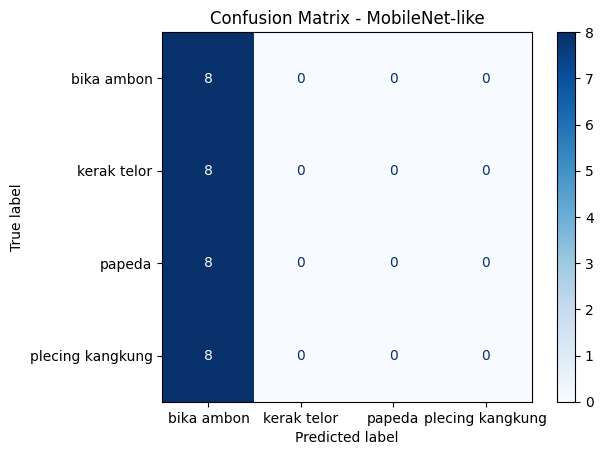

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


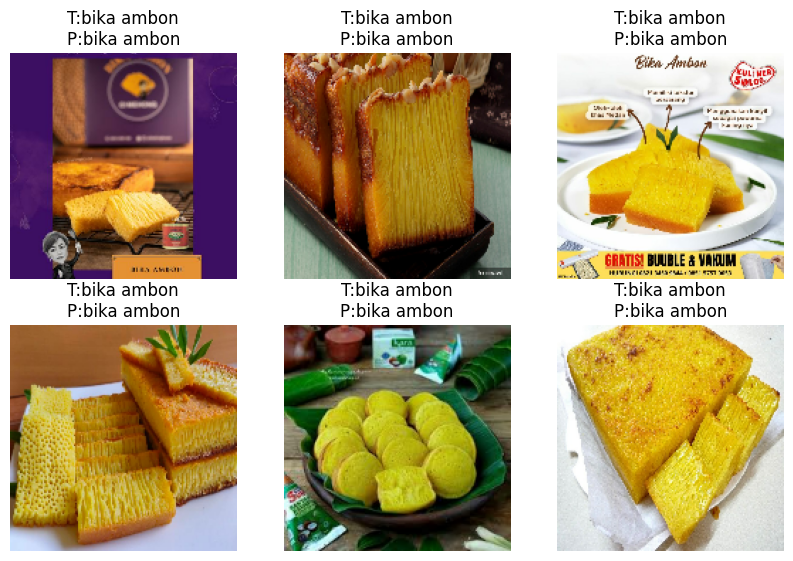

In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss :", test_loss)
print("Test Acc  :", test_acc)

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=CLASS_NAMES_ORDER)
plt.figure(figsize=(5,5))
disp.plot(values_format='d', cmap='Blues')
plt.title("Confusion Matrix - MobileNet-like")
plt.show()

# Tampilkan beberapa prediksi contoh
def show_predictions(dataset, n=6):
    plt.figure(figsize=(10,10))
    idx_plot = 1
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        for i in range(n):
            ax = plt.subplot(3, 3, idx_plot)
            plt.imshow(images[i].numpy().astype("uint8"))
            true_idx = np.argmax(labels[i].numpy())
            pred_idx = np.argmax(preds[i])
            plt.title(f"T:{CLASS_NAMES_ORDER[true_idx]}\nP:{CLASS_NAMES_ORDER[pred_idx]}")
            plt.axis("off")
            idx_plot += 1
    plt.show()

show_predictions(test_ds, n=6)


## 10. Simpan model .h5
model.save("BestModel_MobileNet_like_KelompokX.h5")
print("Model disimpan sebagai BestModel_MobileNet_like_KelompokX.h5")